In [182]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor as cbr
from datetime import datetime as dt
from lightgbm import LGBMRegressor as lbr
from xgboost import XGBRegressor as xgb
from sklearn.ensemble import RandomForestRegressor as rf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import STL

## Presentation Format

Agenda 0.25
Team Members 0.25
Problem Statement - What is the Problem? Why are we doing this? Challenges? Aspects of Solution 0.75
Data Sources - Explain current data (short), External Sources, why we think they are important 0.75
Feature Engineering - Additional features, what are they capturing 1.5 (Black friday curve, product placement in class, discount %, competitor ratio, Prev Day Units, STL decomposition into Trend)
Solution Approaches - Time Series Forecasting, Step wise classification-regression, Regression with Time Series features 0.5
Final Solution & Results - 1.5 Time Series Splitting - Data Leakage - HyperParam Tuning - Model Performance - Prominent Features, RMSE
Deployment - 0.5 Framwork - database, data update cycle, model training, model update cycle,
Drawbacks & Future work - 0.5 Not weighted with value/profit on the product, Overfitting to SKUs with higher mean daily quantities.

In [2]:
def addDateCols(df):
    """
    This function takes in a pandas dataframe as an argument and adds new columns to it based on the 'sales_date' column.
    The new columns are: 
    1. 'day' - day of the month from 'sales_date' column
    2. 'month' - month of the year from 'sales_date' column
    3. 'year' - year from 'sales_date' column
    4. 'day_of_week' - day of the week from 'sales_date' column (Monday is 0 and Sunday is 6)
    Args:
    df : pandas dataframe containing a column 'sales_date' of datetime type
    Returns:
    df : pandas dataframe with new columns added
    """
    df['day']=df['sales_date'].dt.day
    df['month']=df['sales_date'].dt.month
    df['year']=df['sales_date'].dt.year
    df['day_of_week']=df['sales_date'].dt.dayofweek
    return df

In [3]:
data=pd.read_csv("data/Merged3_data.csv")
data = data[~data.Encoded_SKU_ID.isna()]
data = data[[i for i in data.columns if "Unnamed" not in i]]
print(data.shape)
data.head()

(846632, 184)


,Encoded_SKU_ID,SALES_DATE,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,DAILY_UNITS,day,month,year,Movingsum7,...,Inventory_Fully-Stocked,Inventory_Moderate,Inventory_Out-of-Stock,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,1,2017-05-28,89.99,0.0,0.0,0,28,5,2017,0.0,...,1,0,0,0,0,0,1,0,0,0
1,486,2017-05-28,17.99,0.0,0.0,0,28,5,2017,0.0,...,0,0,1,0,0,0,1,0,0,0
2,282,2017-05-28,16.99,0.0,0.0,0,28,5,2017,0.0,...,0,0,1,0,0,0,1,0,0,0
3,180,2017-05-28,16.99,0.0,0.0,0,28,5,2017,0.0,...,0,0,1,0,0,0,1,0,0,0
4,488,2017-05-28,39.99,0.0,0.0,0,28,5,2017,0.0,...,0,0,1,0,0,0,1,0,0,0


In [4]:
data=pd.read_excel("data/Hackathon Data.xlsx",engine='openpyxl')
data = data[~data.Encoded_SKU_ID.isna()]
data = data[[i for i in data.columns if "Unnamed" not in i]]
print(data.shape)
data.head()

(846632, 11)


,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS
0,1.0,2017-09-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,1.0
1,2.0,2017-11-24,CAMERA BATTERIES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,39.99,?,?,Fully-Stocked,18.0
2,3.0,2019-11-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,46.98,Constrained,7.0
3,4.0,2021-04-21,SO RANGEHOODS REG,KITCHEN VENTILATION,ML - Kitchen,VP - Major Appliances,549.99,?,498,Fully-Stocked,6.0
4,1.0,2018-10-27,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,7.0


In [12]:
val=pd.read_excel("data/Validation_Data.xlsx",engine='openpyxl')
val = val[~val.Encoded_SKU_ID.isna()]
val = val[[i for i in val.columns if "Unnamed" not in i]]
print(val.shape)
val.head()

(3773, 12)


,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS,Forecasted Units
0,23.0,2022-08-06,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,?,Moderate,3.0,NaN
1,100.0,2022-08-02,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,16.99,Fully-Stocked,2.0,NaN
2,121.0,2022-08-06,MISC ACCY,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,24.99,?,?,Fully-Stocked,6.0,NaN
3,207.0,2022-08-03,OTR MIC,OTR MICROWAVE,ML - Kitchen,VP - Major Appliances,499.99,?,?,Fully-Stocked,0.0,NaN
4,416.0,2022-08-05,AMPS,CAR STEREO,ML - Connected Car,VP - Electrify & Car,269.99,?,?,Fully-Stocked,9.0,NaN


In [6]:
dow_jones_index = pd.read_csv('data/dow_jones.csv')

In [146]:
gscpi = pd.read_csv('data/gscpi_data.csv',names = ["sales_date", "gscpi"])
gscpi["sales_date"] = pd.to_datetime(gscpi["sales_date"])
owid = pd.read_csv('data/owid-covid-data.csv')
owid = owid[owid["location"]=="United States"][["date", "total_cases", "new_cases"]].rename(columns = {"date":"sales_date"})
owid["sales_date"] = pd.to_datetime(owid["sales_date"])

In [163]:
trend = pd.read_csv('data/norm_trend_all_skus.csv')
trend.columns = [i.lower() for i in trend.columns]
trend = trend[["encoded_sku_id", "sales_date", "norm_trend"]]
trend["sales_date"] = pd.to_datetime(trend["sales_date"])

In [232]:
df = data.copy()
dfv = val.copy()
df = pd.concat([df,dfv])

In [233]:
def addCovidGSCPI(df):
    df = df.merge(owid, how='left', on='sales_date')
    df = df.merge(gscpi, how='left', on='sales_date')
    df = df.merge(trend, how='left', on = ["encoded_sku_id", "sales_date"])
    return df

def addMarket(df):
    """
    This function takes in a pandas dataframe as an argument and adds new columns to it based on the Dow Jones index.
    It first copies the Dow Jones index and converts the date column to datetime format. Then it renames the columns
    of the index dataframe to match the column names of the input dataframe. It then selects the distinct date values
    from the input dataframe and merges it with the index dataframe on the date column. It then fills any missing market
    values with forward fill method and calculates the return and log return of the market. Finally, it merges the 
    market dataframe with the input dataframe on the date column and returns the modified dataframe.
    
    Args:
    df : pandas dataframe containing a column 'sales_date' of datetime type
    
    Returns:
    df : pandas dataframe with new columns added 'market', 'i_return', 'i_return_log'
    """
    index = dow_jones_index.copy()
    index['date'] = pd.to_datetime(index['date'], format="%d-%m-%y")
    index.columns = ['sales_date', 'market']
    dates_df = df[["sales_date"]].drop_duplicates().sort_values("sales_date").reset_index(drop=True)
    index = dates_df.merge(index, how = "left", on="sales_date").sort_values("sales_date").reset_index(drop=True)
    index["market"] = index["market"].fillna(method = "ffill")
    index['i_return'] = index['market'].diff()
    index['i_return_log'] = index['market'].apply(np.log).diff()
    df = df.merge(index, how='left', on='sales_date')
    return df

def cleanNonObjColumns(df):
    """
    This function takes in a pandas dataframe as an argument and performs cleaning and data type conversion on the non-object columns.
    It first converts the column names to lowercase. Then it selects the columns 'encoded_sku_id' and 'daily_units' and converts their data type to int.
    Next, it selects the columns 'retail_price', 'promo_price', 'competitor_price' and replaces any '?' with NaN and converts their data type to float.
    Args:
    df : pandas dataframe
    Returns:
    df : pandas dataframe with cleaned and converted non-object columns
    """
    df.columns = [i.lower() for i in df.columns]
    int_cols = ["encoded_sku_id", "daily_units"]
    df[int_cols] = df[int_cols].astype(int)
    float_cols = ["retail_price", "promo_price", "competitor_price"]
    df[float_cols] = df[float_cols].replace("?", np.nan).astype(float)
    return df

def cleanObjColumns(df):
    """
    This function takes in a pandas dataframe as an argument and performs label encoding on the object columns.
    It first selects all the object columns in the dataframe and stores them in a list 'obj_cols'.
    It creates an empty dictionary 'label_encoders' to store the label encoders for each column.
    It then defines an inner function 'labelEncode' which takes in a column and applies label encoding on it.
    It stores the label encoder object in the 'label_encoders' dictionary with the column name as the key.
    It then applies this inner function on each of the object columns in the dataframe using the 'apply' method.
    It returns the modified dataframe.
    
    Args:
    df : pandas dataframe
    Returns:
    df : pandas dataframe with label encoded object columns
    """
    obj_cols = df.columns[df.dtypes == "object"].tolist()
    label_encoders = {}
    def labelEncode(x):
        le = LabelEncoder()
        le.fit(x)
        label_encoders[x.name] = le
        return le.transform(x)

    df[obj_cols] = df[obj_cols].apply( labelEncode )
    return df


def dateGroupFeats(x):
    """
    This function takes in a pandas dataframe as an argument and creates new columns based on the groupby of 
    specified columns and retail price. 
    It first selects the columns 'subclass_name', 'class_name', 'ml_name', 'category_name' and assigns it to the variable 'cols'.
    Then it iterates over the columns in 'cols' and creates a new column 'retail_price_position_'+c for each column c.
    The new column is created by applying the groupby operation on the input dataframe based on the column c and 
    dividing the retail price by the mean of retail price for each group.
    It returns the modified dataframe
    
    Args:
    x : pandas dataframe
    Returns:
    x : pandas dataframe with new columns 'retail_price_position_'+c for each column c in 'cols'
    """
    cols = ["subclass_name", "class_name", "ml_name", "category_name"]
    for c in cols:
        x['retail_price_position_'+c] = x.groupby(c)["retail_price"].apply(lambda x: x/x.mean())
    return x


def skuGroupFeats(x):
    """
    This function takes in a pandas dataframe as an argument and creates a new column 'units_lag1' based on the 'daily_units' column.
    It first sorts the dataframe by 'sales_date' and creates a new column 'units_lag1' which is the shifted version of the 'daily_units' column by 1.
    It returns the modified dataframe.
    
    Args:
    x : pandas dataframe
    Returns:
    x : pandas dataframe with added column 'units_lag1'
    """
    x=x.sort_values("sales_date")
    x["units_lag1"] = x['daily_units'].shift(1)
    return x

def get_norm_trend(x):
    """
    This function takes in a pandas dataframe as an argument and creates a new column 'trend' based on the 'daily_units' column.
    It uses the STL function from statsmodels package to decompose the time series data in the 'daily_units' column with a period of 365.
    It then takes the trend component and normalizes it by subtracting the mean and dividing by the standard deviation.
    It then adds the normalized trend as a new column 'trend' in the input dataframe.
    It returns the modified dataframe.
    
    Args:
    x : pandas dataframe
    Returns:
    x : pandas dataframe with added column 'trend'
    """
    res = STL(x["daily_units"], period=365).fit()
    trend = res.trend
    x["trend"] = (trend-trend.mean())/trend.std()
    return x


def featureEng(df):
    """
    This function takes in a pandas dataframe as an argument and performs feature engineering on it.
    It first converts the 'sales_date' column to int64, divides it by 1e9 and assigns it back to the same column.
    It then creates a new column 'competitor_price_ratio' which is the ratio of 'competitor_price' to 'retail_price' columns.
    It creates a new column 'discount' which is the difference of 1 and the ratio of 'promo_price' to 'retail_price' columns.
    It creates a new column 'black_friday' which is a binary column denoting whether the sale date is a black friday or not.
    It then creates a new column 'black_friday' which is a column that denotes the proximity of the sale date to the nearest black friday.
    The proximity is calculated by taking the minimum difference of the date and all the black friday dates and dividing it by 691200 (number of seconds in 8 days).
    It applies the 'dateGroupFeats' function on the dataframe grouped by 'sales_date' and then applies the 'skuGroupFeats' function on the dataframe grouped by 'encoded_sku_id'.
    It returns the modified dataframe.
    """
    df["sales_date"] = df.sales_date.astype('int64')/1e9
    df["competitor_price_ratio"] = df["competitor_price"]/df["retail_price"]
    df["discount"] = 1 - (df["promo_price"]/df["retail_price"])
    df["black_friday"] = ((df["month"]==11) & (df["day_of_week"]==4) & (df["day"]<=29) & (df["day"]>=23)).astype(int)
    bf_days = df[df["black_friday"]==1]["sales_date"].unique()
    df["black_friday"] = df["sales_date"].apply( lambda x: max(0,1 - (np.abs(bf_days-x).min()/691200)) )
    df = df.groupby("sales_date").apply(dateGroupFeats)
    df = df.groupby("encoded_sku_id").apply(skuGroupFeats).droplevel(0)
    return df

def fillMissingDates(x, s, e):
    """
    This function takes in a pandas dataframe, a start date and an end date as arguments.
    It sorts the input dataframe by 'sales_date' column and separates the rows with 'sales_date' greater than the end date.
    It then filters the input dataframe to only keep the rows with 'sales_date' less than or equal to the end date.
    It sets the 'sales_date' column as index and reindexes the dataframe with date range from the start date to end date.
    It fills any missing values in the dataframe using forward fill and backward fill.
    It renames the index as 'sales_date' and resets the index of the dataframe.
    It concatenates the filtered dataframe with the rows that were separated earlier.
    It returns the modified dataframe.
    
    Args:
    x : pandas dataframe
    s : start date as string in format 'YYYY-MM-DD'
    e : end date as string in format 'YYYY-MM-DD'
    Returns:
    x : pandas dataframe with missing dates filled and sorted by 'sales_date'
    """
    x = x.sort_values("sales_date")
    x1 = x[x["sales_date"]>e]
    x = x[x["sales_date"]<=e]
    x = x.set_index('sales_date').reindex(
        pd.date_range(s, e)
    ).fillna(method='ffill').fillna(method='bfill').rename_axis('sales_date').reset_index()
    x = pd.concat([x,x1])
    return x

def cleanData(df):
    """
    This function takes in a pandas dataframe as an input.
    It first calls the 'cleanNonObjColumns' function to clean up the non-object columns of the dataframe.
    It then replaces all negative values in the 'daily_units' column with 0.
    It then extracts the earliest and the 8th last date from the 'sales_date' column and assigns them as start and end dates.
    It groups the dataframe by 'encoded_sku_id' column and applies the 'fillMissingDates' function on each group.
    It then calls the 'addMarket' function, 'addCovidGSCPI' function, 'addDateCols' function and 'cleanObjColumns' function in that order.
    It then calls the 'featureEng' function on the dataframe.
    It sorts the dataframe by 'sales_date' and 'encoded_sku_id' columns and resets the index of the dataframe.
    It returns the cleaned and transformed dataframe.
    
    Args:
    df : pandas dataframe
    Returns:
    df : cleaned and transformed dataframe
    """
    df = cleanNonObjColumns(df)
    df["daily_units"] = np.where(df.daily_units<0, 0, df.daily_units)
    dates = sorted(df.sales_date.unique())
    start, end = dates[0],dates[-8]
    df = df.groupby('encoded_sku_id').apply(lambda x: fillMissingDates(x, start, end))
    df = addMarket(df)
    df = addCovidGSCPI(df)
    df = addDateCols(df)
    df = cleanObjColumns(df)
    df = featureEng(df)
    df = df.sort_values(["sales_date", "encoded_sku_id"]).reset_index(drop=True)
    return df

In [234]:
df = cleanData(df)

In [231]:
df.head(10)

,sales_date,encoded_sku_id,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,...,year,day_of_week,competitor_price_ratio,discount,black_friday,retail_price_position_subclass_name,retail_price_position_class_name,retail_price_position_ml_name,retail_price_position_category_name,units_lag1
0,1.495930e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,6,0.833315,0.166685,0.0,1.180561,0.962282,0.955523,0.237436,NaN
1,1.496016e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,0,0.833315,0.166685,0.0,1.176578,0.958747,0.952363,0.236939,0.0
2,1.496102e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,1,0.833315,0.166685,0.0,1.174596,0.961219,0.954573,0.237150,0.0
3,1.496189e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,2,0.833315,0.166685,0.0,1.176082,0.958219,0.951891,0.237335,0.0
4,1.496275e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,3,0.833315,0.166685,0.0,1.182062,0.959452,0.952994,0.237107,0.0
5,1.496362e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,4,0.833315,0.166685,0.0,1.183567,0.964060,0.957111,0.237632,0.0
6,1.496448e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,5,0.833315,0.166685,0.0,1.183567,0.960423,0.953862,0.237493,4.0
7,1.496534e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,6,0.833315,0.166685,0.0,1.183567,0.964060,0.957111,0.237632,7.0
8,1.496621e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,0,0.833315,0.166685,0.0,1.183567,0.964060,0.957111,0.237632,4.0
9,1.496707e+09,1.0,43,7,1,0,89.99,74.99,74.99,1,...,2017,1,0.833315,0.166685,0.0,1.183567,0.964060,0.957111,0.237144,2.0


In [235]:
def createTrTs(df, splits=10, test_size=7):
    """
    This function takes in a pandas dataframe and splits it into train and test sets.
    It first extracts all unique dates in the 'sales_date' column and sorts them.
    It then selects the last 'test_size' number of dates and assigns them as the test set.
    It splits the remaining dates into 'splits' number of train sets.
    It then creates a list of test sets by taking the first 'test_size' number of dates from each of the train sets except the first one and appending the last test set.
    It returns the train sets and test sets as two separate lists.
    
    Args:
    df : pandas dataframe
    splits : number of splits for train sets, default value is 10
    test_size : number of last dates to be selected as test set, default value is 7
    
    Returns:
    trains : list of train sets
    tests : list of test sets
    """
    dates = np.array(sorted(df.sales_date.unique()))
    test = dates[-test_size:]
    dates = dates[:-test_size]
    trains = np.array_split(dates,splits)
    tests = [i[:test_size] for i in trains[1:]] + [test]
    return trains, tests

def generateTimeSeriesSplits(trains, tests, df):
    """
    This function takes in a list of train sets, a list of test sets and the original dataframe.
    It iterates over the test sets and for each test set, it concatenates all the train sets up to that point.
    It then creates a train set and a test set by filtering the original dataframe based on the sales dates present in the train and test sets respectively.
    It sorts these dataframes by encoded_sku_id and sales_date and resets the index.
    It returns a tuple of the train and test sets for each iteration.
    
    Args:
    trains : list of train sets
    tests : list of test sets
    df : original dataframe
    
    Returns:
    tr : train set
    ts : test set
    """
    for i, ts in enumerate(tests):
        tr = np.concatenate(trains[:i+1])
        tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(ts)].copy()
        yield tr.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True),ts.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True)

trains, tests = createTrTs(df)

In [168]:
def func(x):
    x=x.sort_values("sales_date")
    x["units_lag1"] = x['daily_units'].shift(1)
    #x["units_mean7"]=x['daily_units'].rolling(window=7).mean().shift(1)
    # x["movingsum5"]=x['daily_units'].rolling(window=5).mean().shift(1)
    # x["movingsum3"]=x['daily_units'].rolling(window=3).sum().shift(1)
    # x["movingvar7"]=x['daily_units'].rolling(window=7).var().shift(1)
    # x["movingvar5"]=x['daily_units'].rolling(window=5).var().shift(1)
    # x["movingvar3"]=x['daily_units'].rolling(window=3).var().shift(1)
    # cols=[i for i in x.columns if ("moving" in i)]
    # x.reset_index(inplace=True,drop=True)
    # x.loc[int(0.9*len(x)):,cols]=np.nan
    # x[cols]=x[cols].fillna(method="ffill")
    return x

In [176]:
df[df.sales_date.isin(tests[-2])]

,sales_date,encoded_sku_id,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,...,month,year,day_of_week,competitor_price_ratio,discount,black_friday,retail_price_position_subclass_name,retail_price_position_class_name,retail_price_position_ml_name,retail_price_position_category_name
978650,1.642982e+09,1.0,43,7,1,0,89.99,74.99,68.90,1,...,1,2022,0,0.765641,0.166685,0.0,1.159159,0.951683,0.979675,0.249975
978651,1.642982e+09,2.0,7,7,1,0,39.99,23.99,68.78,1,...,1,2022,0,1.719930,0.400100,0.0,0.848453,0.422911,0.435350,0.111085
978652,1.642982e+09,3.0,88,18,0,1,49.99,44.99,40.84,3,...,1,2022,0,0.816963,0.100020,0.0,1.710043,1.552116,0.625491,0.609308
978653,1.642982e+09,4.0,92,15,4,2,549.99,399.99,549.00,1,...,1,2022,0,0.998200,0.272732,0.0,0.577010,0.715942,0.346528,0.387646
978654,1.642982e+09,5.0,61,18,0,1,16.99,12.74,13.38,1,...,1,2022,0,0.787522,0.250147,0.0,0.617642,0.527514,0.212584,0.207084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982670,1.643501e+09,571.0,11,7,1,0,599.99,NaN,599.00,1,...,1,2022,6,0.998350,NaN,0.0,2.823615,6.314641,6.502470,1.663357
982671,1.643501e+09,572.0,48,7,1,0,129.99,59.99,129.99,1,...,1,2022,6,1.000000,0.538503,0.0,1.374662,1.368090,1.408784,0.360372
982672,1.643501e+09,573.0,112,7,1,0,104.99,69.99,48.99,1,...,1,2022,6,0.466616,0.333365,0.0,1.354212,1.104975,1.137843,0.291065
982673,1.643501e+09,574.0,35,7,1,0,21.99,NaN,21.99,1,...,1,2022,6,1.000000,NaN,0.0,1.000000,0.231435,0.238319,0.060963


In [245]:
import optuna

In [246]:
def objective(trial):
    """
    This function is using Optuna library to perform a hyperparameter tuning for an XGBoost model. 
    The function takes a dataframe as input, and splits it into a train and test set using the generateTimeSeriesSplits function. 
    It then uses the Optuna library to perform a random search of the hyperparameter space to find the best set of hyperparameters. 
    The parameters being tuned are max_depth, eta, colsample_bytree, and gamma.
    It then fits an XGBoost model with the best hyperparameters on the training data, and predicts on the test set. 
    The objective of the tuning is to minimize the Root Mean Squared Error (RMSE) of the predictions on the test set.
    It returns the RMSE of the predictions on the test set.
    """
    generator = generateTimeSeriesSplits(trains, tests, df)
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'eta': trial.suggest_uniform('eta', 0.01, 0.2),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'gamma' : trial.suggest_uniform('gamma', 0.1, 10),
    }
    for i,ts in enumerate(tests):
        tr,ts = next(generator)
        if i<9:
            continue
        reg = xgb(**params)
        xtr,ytr = tr.drop("daily_units", axis=1), tr["daily_units"]
        ts_save =  ts.copy()
        reg.fit(xtr,ytr)
        yts = reg.predict(ts.drop("daily_units",axis=1))
    return mean_squared_error(ts_save["daily_units"], yts, squared=False)



In [247]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-01-19 13:36:32,321] A new study created in memory with name: no-name-6f6ea080-6b20-4a58-b98f-3038261ab405
[I 2023-01-19 13:37:22,455] Trial 0 finished with value: 7.089884575940858 and parameters: {'max_depth': 4, 'eta': 0.1777278748531542, 'colsample_bytree': 0.4062761718802905, 'gamma': 7.453596156135384}. Best is trial 0 with value: 7.089884575940858.
[I 2023-01-19 13:37:51,614] Trial 1 finished with value: 6.643998737036043 and parameters: {'max_depth': 2, 'eta': 0.16256038660506283, 'colsample_bytree': 0.35604713668438204, 'gamma': 3.1856766869806434}. Best is trial 1 with value: 6.643998737036043.
[I 2023-01-19 13:39:07,735] Trial 2 finished with value: 5.30996576312021 and parameters: {'max_depth': 5, 'eta': 0.17555048960497974, 'colsample_bytree': 0.6931493979822769, 'gamma': 9.79584987650468}. Best is trial 2 with value: 5.30996576312021.
[I 2023-01-19 13:40:04,202] Trial 3 finished with value: 9.41939220429218 and parameters: {'max_depth': 4, 'eta': 0.0775683621701692

In [248]:
study.best_params

{'max_depth': 3,
 'eta': 0.1390088634571252,
 'colsample_bytree': 0.9500837705904258,
 'gamma': 7.079548559337446}

In [257]:
tr = np.concatenate(trains)
tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(tests[-1])].copy()
tr,ts = tr.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True),ts.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True)

def objective(trial):
    """
    This function is an objective function for an optimization algorithm. It is used to optimize the parameters of a lightgbm regressor (lbr) to minimize the mean squared error between the predicted values and actual values.

    The function takes a trial object as input, which is used to suggest the parameter values for the optimization. The parameters being optimized are:

    max_depth: the maximum depth of the decision tree
    reg_alpha: L1 regularization term on weights
    reg_lambda: L2 regularization term on weights
    num_leaves: the number of leaves in the tree
    
    The function then creates an instance of the lightgbm regressor with the suggested parameter values, and trains the model on the input data (tr) and 
    corresponding target values (daily_units). Then it makes prediction on the test data (ts) and calculates the mean squared error between the predicted values and actual values. 
    The function returns the square root of the mean squared error as the final output.
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'reg_alpha': trial.suggest_uniform('lambda_l1', 0.001, 1),
        'reg_lambda': trial.suggest_uniform('lambda_l2', 0.001, 1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 10),
    }

    reg = lbr(**params)
    xtr,ytr = tr.drop("daily_units", axis=1), tr["daily_units"]
    ts_save =  ts.copy()
    reg.fit(xtr,ytr)
    yts = reg.predict(ts.drop("daily_units",axis=1))
    return mean_squared_error(ts_save["daily_units"], yts, squared=False)

study2 = optuna.create_study()
study2.optimize(objective, n_trials=100)
study2.best_params

[I 2023-01-19 16:36:21,221] A new study created in memory with name: no-name-e0c67948-402e-4140-b468-e9533049278b
[I 2023-01-19 16:36:25,529] Trial 0 finished with value: 4.397049947743128 and parameters: {'max_depth': 2, 'lambda_l1': 0.6239397985704198, 'lambda_l2': 0.04485668223194441, 'num_leaves': 8}. Best is trial 0 with value: 4.397049947743128.
[I 2023-01-19 16:36:30,070] Trial 1 finished with value: 3.113531140204509 and parameters: {'max_depth': 5, 'lambda_l1': 0.5426954491281121, 'lambda_l2': 0.25450897390767163, 'num_leaves': 9}. Best is trial 1 with value: 3.113531140204509.
[I 2023-01-19 16:36:35,093] Trial 2 finished with value: 4.195304138285659 and parameters: {'max_depth': 2, 'lambda_l1': 0.4168568039620813, 'lambda_l2': 0.7946999432837728, 'num_leaves': 8}. Best is trial 1 with value: 3.113531140204509.
[I 2023-01-19 16:36:39,739] Trial 3 finished with value: 3.2468048694564895 and parameters: {'max_depth': 3, 'lambda_l1': 0.47249644925229073, 'lambda_l2': 0.086253542

{'max_depth': 4,
 'lambda_l1': 0.29719719373159487,
 'lambda_l2': 0.11176965177998135,
 'num_leaves': 8}

In [259]:
tr = np.concatenate(trains)
tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(tests[-1])].copy()
tr,ts = tr.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True),ts.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True)

def objective(trial):
    """
    The function objective(trial) is using Optuna library to perform a hyperparameter optimization for the LightGBM model. 
    The trial object is passed to the function and it uses the suggest methods of this object to sample the hyperparameters.

    The function sets the initial values for the parameters like max_depth, reg_alpha, reg_lambda, num_leaves 
    and then it creates a LightGBM model object with these parameters.

    The function then takes the training data and trains the model on it. 
    After that, it uses the predict method of the model to predict the units for the test data.

    The function then defines a nested function moving_fill(x) that takes in a dataframe and for each encoded_sku_id it applies 
    the predictions of the model on the test data and updates the predicted values for the next day based on the previous days predictions.

    Finally, the function returns the mean squared error between the predicted and actual values of the test data.
    """

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'reg_alpha': trial.suggest_uniform('lambda_l1', 0.001, 1),
        'reg_lambda': trial.suggest_uniform('lambda_l2', 0.001, 1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 10),
    }

    reg = lbr(**params)
    xtr,ytr = tr.drop("daily_units", axis=1), tr["daily_units"]
    ts_save =  ts.copy()

    reg.fit(xtr,ytr)

    def moving_fill(x):
        temp = tr[tr['encoded_sku_id']==x['encoded_sku_id'].iloc[0]].reset_index(drop=True)
        x = x.reset_index(drop=True)
        for i in range(x.shape[0]):
            prev = temp["daily_units"].iloc[-1] if temp.shape[0]>0 else np.nan
            x.loc[i,"units_lag1"] = x.loc[i-1, "daily_units"] if i>0 else prev
            x.loc[i,'daily_units'] = reg.predict(x.drop(['daily_units'],axis=1).iloc[i:i+1,:])
            # print('S')
        return x

    ts_pred = ts.groupby('encoded_sku_id', as_index=False).apply(moving_fill)
    return mean_squared_error(ts_save["daily_units"], ts_pred["daily_units"], squared=False)

study3 = optuna.create_study()
study3.optimize(objective, n_trials=100)
study3.best_params

[I 2023-01-19 16:52:44,455] A new study created in memory with name: no-name-fb2b2ea8-1836-4468-8688-5b0447523271
[I 2023-01-19 16:53:20,273] Trial 0 finished with value: 5.03571335557365 and parameters: {'max_depth': 2, 'lambda_l1': 0.5918479752722454, 'lambda_l2': 0.9452545106650195, 'num_leaves': 8}. Best is trial 0 with value: 5.03571335557365.
[I 2023-01-19 16:53:54,411] Trial 1 finished with value: 5.027818241686482 and parameters: {'max_depth': 2, 'lambda_l1': 0.4628058740364966, 'lambda_l2': 0.032830116803470026, 'num_leaves': 6}. Best is trial 1 with value: 5.027818241686482.
[I 2023-01-19 16:54:28,536] Trial 2 finished with value: 4.092215205751255 and parameters: {'max_depth': 4, 'lambda_l1': 0.676645972159246, 'lambda_l2': 0.7586050883880655, 'num_leaves': 7}. Best is trial 2 with value: 4.092215205751255.
[I 2023-01-19 16:55:03,169] Trial 3 finished with value: 3.725308343765572 and parameters: {'max_depth': 4, 'lambda_l1': 0.7430677717502892, 'lambda_l2': 0.22023250979441

{'max_depth': 3,
 'lambda_l1': 0.2045319465453519,
 'lambda_l2': 0.4200809674677322,
 'num_leaves': 7}

In [241]:

    reg = xgb(max_depth=, gamma=5, eta=0.2)
    #reg = lbr(max_depth=2)
    tr,ts = next(generator)
    # tr = np.concatenate(trains[:i+1])
    # tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(ts)].copy()
    #tr = tr.groupby("encoded_sku_id", as_index=False)#.apply(func).sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True)

    xtr,ytr = tr.drop("daily_units", axis=1), tr["daily_units"]
    ts_save =  ts.copy()

    reg.fit(xtr,ytr)

    # def moving_fill(x):
    #     temp = tr[tr['encoded_sku_id']==x['encoded_sku_id'].iloc[0]].reset_index(drop=True)
    #     x = x.reset_index(drop=True)
    #     for i in range(x.shape[0]):
    #         prev = temp["daily_units"].iloc[-1] if temp.shape[0]>0 else np.nan
    #         x.loc[i,"units_lag1"] = x.loc[i-1, "daily_units"] if i>0 else prev
    #         x.loc[i,'daily_units'] = reg.predict(x.drop(['daily_units'],axis=1).iloc[i:i+1,:])
    #         # print('S')
    #     return x

    #ts = ts.groupby('encoded_sku_id', as_index=False).apply(moving_fill)
    yts = reg.predict(ts.drop("daily_units",axis=1))
    print(reg.score(xtr,ytr),r2_score(ts_save["daily_units"], yts))
    print(mean_squared_error(ts_save["daily_units"], ts['daily_units'], squared=False))

0.9543489072228925 0.8788541333817268
6.513416458860128
0.957660843145044 0.9126197005858573
4.180163148916075


In [199]:
ts.columns

Index(['sales_date', 'encoded_sku_id', 'subclass_name', 'class_name',
       'ml_name', 'category_name', 'retail_price', 'promo_price',
       'competitor_price', 'inventory', 'daily_units', 'forecasted units',
       'market', 'i_return', 'i_return_log', 'total_cases', 'new_cases',
       'gscpi', 'norm_trend', 'day', 'month', 'year', 'day_of_week',
       'competitor_price_ratio', 'discount', 'black_friday',
       'retail_price_position_subclass_name',
       'retail_price_position_class_name', 'retail_price_position_ml_name',
       'retail_price_position_category_name', 'units_lag1'],
      dtype='object')

In [210]:
reg = lbr(max_depth=1)
xtr,ytr = ts.drop("daily_units", axis=1), ts["daily_units"]
reg.fit(xtr,ytr)

LGBMRegressor(max_depth=1)

In [211]:
dfn =tr.copy()
dfn["pred"] = reg.predict(tr.drop("daily_units", axis=1))

def jugaad(x):
    return mean_squared_error(x.daily_units, x.pred)
pred = dfn.groupby("sales_date").apply(jugaad)

In [212]:
pred.sort_values()

sales_date
1.522541e+09         1.142040
1.496102e+09         3.255645
1.496189e+09         3.255645
1.496275e+09         3.255645
1.496016e+09         3.255645
                    ...      
1.542845e+09    167158.423748
1.606435e+09    208411.070719
1.576714e+09    229307.554938
1.574899e+09    353523.247203
1.574986e+09    705404.082808
Length: 1891, dtype: float64

In [213]:
reg.score(xtr,ytr)

0.9397724863257658

In [180]:
from lightgbm import LGBMClassifier as lbc

In [189]:
generator = generateTimeSeriesSplits(trains, tests, df)
for i,ts in enumerate(tests):
    #reg = xgb(max_depth=2, gamma=5, eta=0.2)
    reg = lbc(max_depth=2, is_unbalance=True)
    tr,ts = next(generator)
    # tr = np.concatenate(trains[:i+1])
    # tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(ts)].copy()
    tr = tr.groupby("encoded_sku_id", as_index=False).apply(func).sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True)

    xtr,ytr = tr.drop("daily_units", axis=1), tr["daily_units"]
    ts_save =  ts.copy()

    reg.fit(xtr,(ytr>0).astype(int))

    def moving_fill(x):
        temp = tr[tr['encoded_sku_id']==x['encoded_sku_id'].iloc[0]].reset_index(drop=True)
        x = x.reset_index(drop=True)
        for i in range(x.shape[0]):
            prev = temp["daily_units"].iloc[-1] if temp.shape[0]>0 else np.nan
            x.loc[i,"units_lag1"] = x.loc[i-1, "daily_units"] if i>0 else prev
            x.loc[i,'daily_units'] = reg.predict(x.drop(['daily_units'],axis=1).iloc[i:i+1,:])
            # print('S')
        return x

    ts = ts.groupby('encoded_sku_id', as_index=False).apply(moving_fill)

    print(reg.score(xtr,(ytr>0).astype(int)),accuracy_score( (ts_save["daily_units"]>0).astype(int), (ts['daily_units']>0).astype(int)) )
    #print(mean_squared_error(ts_save["daily_units"], ts['daily_units'], squared=False))

0.9518169336384439 0.9522981366459627
0.9417506022714237 0.8966459627329193
0.9284353949785671 0.9237267080745342
0.9179254494285222 0.9001242236024845
0.9046824156632043 0.8054658385093167
0.889829534571921 0.8464596273291926
0.8829003021148036 0.8191304347826087
0.8748400816115406 0.8216149068322981
0.8670914014203239 0.7440993788819876
0.8560973030142781 0.6891068115557911


In [191]:
from sklearn.metrics import confusion_matrix
confusion_matrix((ts_save["daily_units"]>0).astype(int), (ts['daily_units']>0).astype(int))

array([[ 492,  543],
       [ 630, 2108]], dtype=int64)

In [178]:
(ts["daily_units"].reset_index(drop=True) - ts_save["daily_units"].reset_index(drop=True)).mean()

-0.26735888724761453

In [173]:
pd.concat([ts["daily_units"].reset_index(drop=True), ts_save["daily_units"].reset_index(drop=True)], axis=1)

,daily_units,daily_units
0,1.221341,0.0
1,1.221341,1.0
2,1.410993,0.0
3,1.410993,0.0
4,1.410993,1.0
...,...,...
3768,1.410993,1.0
3769,1.410993,0.0
3770,1.410993,0.0
3771,1.410993,0.0


In [172]:
pd.DataFrame(reg.feature_importances_ , index= xtr.columns.tolist(), columns = ["feature_imp"]).sort_values("feature_imp", ascending = False)

,feature_imp
units_lag1,183
discount,24
black_friday,21
day_of_week,16
promo_price,14
norm_trend,8
encoded_sku_id,7
inventory,2
new_cases,2
retail_price_position_subclass_name,1


## End of main solution rest is playing around

In [ ]:
ts.tail()

In [ ]:
ts_save.tail()

In [19]:


    def f_fill(x):
        temp = tr[tr['encoded_sku_id']==x['encoded_sku_id'].iloc[0]].reset_index(drop=True)
        if temp.shape[0]:
            dum = temp[cols].iloc[-1,:]
            for c in cols:
                x[c] = dum[c]
        else:
            x[cols] = 0
        return x

    ts = ts.groupby('encoded_sku_id', as_index=False).apply(f_fill).reset_index(drop=True)

    xtr,ytr = tr.drop("daily_units", axis=1), tr["daily_units"]
    xts,yts = ts.drop("daily_units", axis=1), ts["daily_units"].copy()
    print(xts[['day', 'month', 'year']].drop_duplicates())

    reg.fit(xtr,ytr)

    def moving_fill(x):
        temp = tr[tr['encoded_sku_id']==x['encoded_sku_id'].iloc[0]].reset_index(drop=True)
        x = x.reset_index(drop=True)

        n = temp.shape[0]
        n1 = x.shape[0]

        for i in range(7):
            if i==n1: break
            for c in cols:
                x.loc[i,c] = np.mean(pd.concat([temp.loc[n-7+i:,c],x.loc[:i-1,c]]))
            x.loc[i,'daily_units'] = reg.predict(x.drop(['daily_units'],axis=1).iloc[i:i+1,:])
            # print('S')
        return x

    # print(xts.shape)
    ts = ts.groupby('encoded_sku_id', as_index=False).apply(moving_fill)
    # print(ts.shape)

    # mms = MinMaxScaler()
    # ytr = mms.fit_transform(ytr.apply(lambda x: np.log10(1+x)).values.reshape(-1, 1)).reshape(-1)
    # yts = mms.transform(yts.apply(lambda x: np.log10(1+x)).values.reshape(-1, 1)).reshape(-1)

    print(reg.score(xtr,ytr),reg.score(xts,yts))
    print(mean_squared_error(yts, ts['daily_units'], squared=False))
    # def inverse(x):
    #     return (10**mms.inverse_transform(x.reshape(-1,1))).reshape(-1) -1
    # print(mean_squared_error(inverse(yts), inverse(pred), squared=False))

      day  month  year
0       3     12  2017
244     4     12  2017
485     5     12  2017
731     6     12  2017
977     7     12  2017
1225    8     12  2017
1473    9     12  2017
(1720, 15)
(1720, 16)
0.8746058806030268 0.8638213323534943
29.98597616258507
      day  month  year
0      10      6  2018
375    11      6  2018
750    12      6  2018
1125   13      6  2018
1500   14      6  2018
1876   15      6  2018
2252   16      6  2018
(2628, 15)
(2628, 16)
0.8210897545438773 0.8526608555322662
21.8233984032616
      day  month  year
0      16     12  2018
403    17     12  2018
806    18     12  2018
1209   19     12  2018
1612   20     12  2018
2014   21     12  2018
2417   22     12  2018
(2820, 15)
(2820, 16)
0.7109246502420397 0.8334287597952978
201.25470974310727
      day  month  year
0      23      6  2019
440    24      6  2019
880    25      6  2019
1320   26      6  2019
1760   27      6  2019
2199   28      6  2019
2639   29      6  2019
(3079, 15)
(3079, 16)
0.807591

In [91]:
(ts_save.daily_units.values-ts.daily_units.values).mean()

-0.5895199528925648

c:\programdata\anaconda3\envs\cleanmf\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot: >

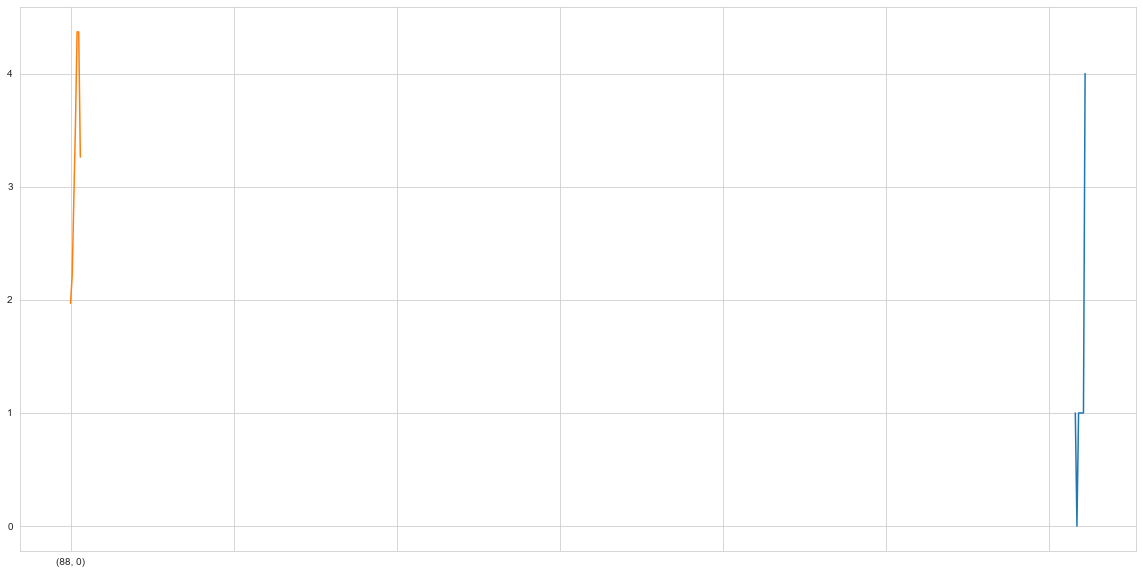

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ts_save[ts_save["encoded_sku_id"]==97].daily_units.plot(ax=ax)
ts[ts["encoded_sku_id"]==97].daily_units.plot(ax=ax)

c:\programdata\anaconda3\envs\cleanmf\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


TypeError: inner() got multiple values for argument 'ax'

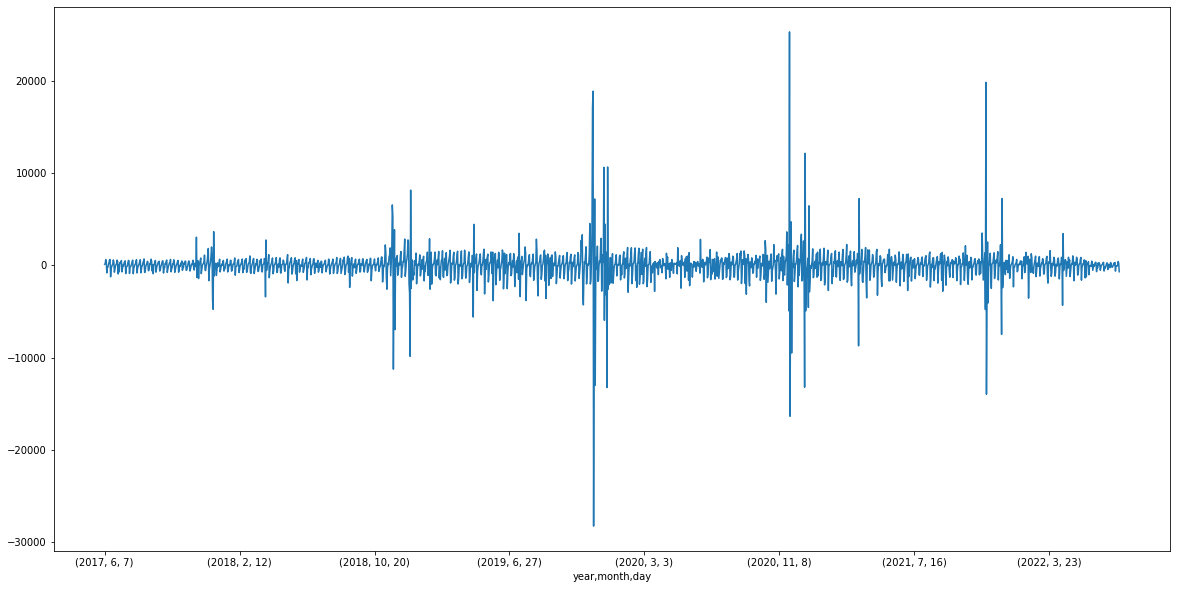

In [269]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
df.groupby(['year','month','day'])['daily_units'].sum().diff().iloc[10:].plot().bar(ax=ax)

c:\programdata\anaconda3\envs\cleanmf\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


TypeError: inner() got multiple values for argument 'ax'

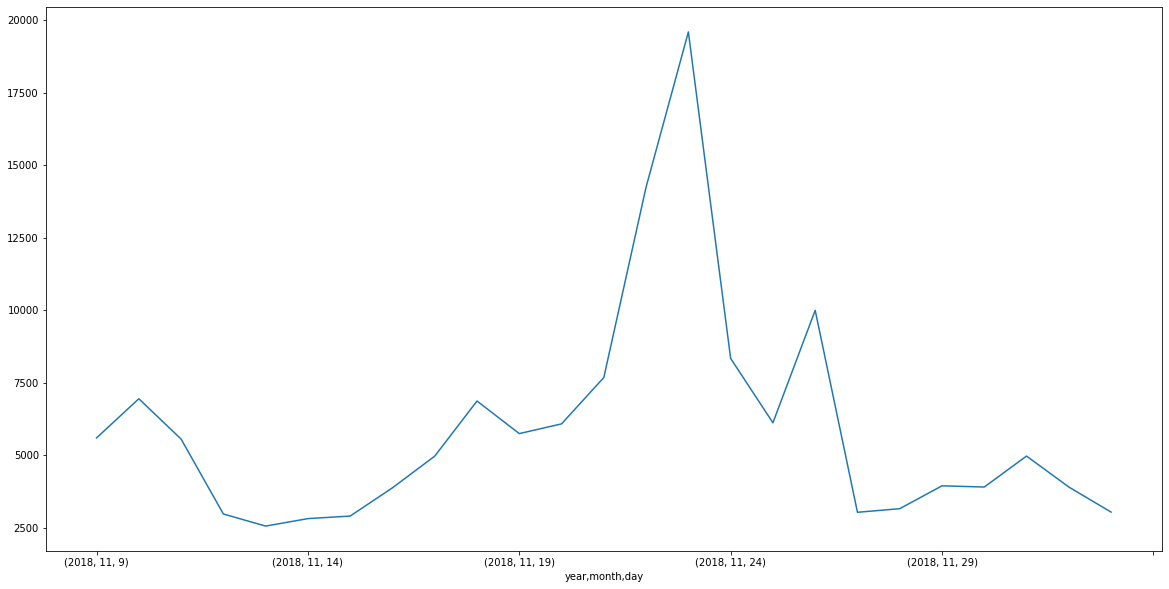

In [295]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
dum = df.groupby(['year','month','day'])['daily_units'].sum().iloc[530:555]
dum.plot().bar(ax=ax)

In [264]:
df.groupby(['year','month','day'])['daily_units'].sum().sort_values(ascending=False)

year  month  day
2019  11     29     47056
2020  11     27     32389
2019  11     28     28144
2021  11     26     23455
2019  12     19     20874
                    ...  
2017  6      1          0
      5      31         0
             30         0
             29         0
             28         0
Name: daily_units, Length: 1891, dtype: int32

In [16]:
yts.head()

0    0
1    4
2    0
3    1
4    9
Name: daily_units, dtype: int32

In [17]:
ts.head()

encoded_sku_id    sales_date  subclass_name  class_name  ml_name  \
0 0               1  1.658707e+09             43           7        1   
  1               1  1.658794e+09             43           7        1   
  2               1  1.658880e+09             43           7        1   
  3               1  1.658966e+09             43           7        1   
  4               1  1.659053e+09             43           7        1   

     category_name  retail_price  promo_price  competitor_price  inventory  \
0 0              0         89.99          NaN             68.90          1   
  1              0         89.99          NaN               NaN          1   
  2              0         89.99          NaN               NaN          1   
  3              0         89.99          NaN               NaN          1   
  4              0         89.99          NaN             69.95          1   

     daily_units  day  month  year  day_of_week  units_mean7  
0 0     1.581630   25      7  2022            1     1.551020  
  1     0.883752   26      7  2022            5     1.568513  
  2     0.883752   27      7  2022            6     1.608913  
  3     1.218379   28      7  2022            4     1.593860  
  4     1.725366   29      7  2022            0     1.556248

In [15]:
pd.DataFrame(reg.feature_importances_ , index= xtr.columns.tolist(), columns = ["feature_imp"]).sort_values("feature_imp", ascending = False)

,feature_imp
units_mean7,168
promo_price,64
day_of_week,35
retail_price,11
encoded_sku_id,9
inventory,9
day,2
sales_date,1
month,1
subclass_name,0


<AxesSubplot: >

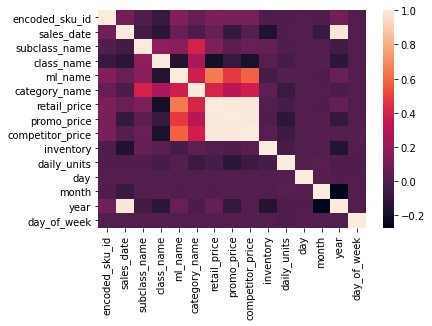

In [115]:
import seaborn as sns
sns.heatmap(df.corr())

In [86]:
df.groupby("encoded_sku_id")["daily_units"].mean().sort_values(ascending=False)

encoded_sku_id
97     1023.159634
237     436.547715
469     383.666380
347     207.240784
557     180.306569
          ...     
318       0.687534
177       0.679731
329       0.663020
158       0.650474
166       0.612381
Name: daily_units, Length: 575, dtype: float64

In [178]:
def createTrTs(df, splits=10, test_size=7):
    dates = np.array(sorted(df.sales_date.unique()))
    test = dates[-test_size:]
    dates = dates[:-test_size]
    trains = np.array_split(dates,splits)
    tests = [i[:test_size] for i in trains[1:]] + [test]
    return trains, tests

def generateTimeSeriesSplits(trains, tests, df):
    for i, ts in enumerate(tests):
        tr = np.concatenate(trains[:i+1])
        tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(ts)].copy()
        yield tr,ts

trains, tests = createTrTs(df)

In [192]:
df

,encoded_sku_id,sales_date,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,daily_units,day,month,year,day_of_week
0,1,1.495930e+09,43,7,1,0,89.99,NaN,NaN,1,0,28,5,2017,3
1,2,1.495930e+09,7,7,1,0,39.99,NaN,NaN,3,0,28,5,2017,3
2,5,1.495930e+09,61,18,0,1,16.99,NaN,NaN,1,0,28,5,2017,3
3,6,1.495930e+09,107,18,0,1,62.99,NaN,NaN,1,0,28,5,2017,3
4,7,1.495930e+09,61,18,0,1,16.99,NaN,NaN,3,0,28,5,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846627,571,1.659226e+09,11,7,1,0,599.99,NaN,488.88,1,1,31,7,2022,3
846628,572,1.659226e+09,48,7,1,0,129.99,NaN,NaN,1,2,31,7,2022,3
846629,573,1.659226e+09,112,7,1,0,104.99,NaN,NaN,1,0,31,7,2022,3
846630,574,1.659226e+09,35,7,1,0,21.99,NaN,21.51,1,2,31,7,2022,3


In [215]:
data_gen = generateTimeSeriesSplits(trains, tests, df)
for i,ts in enumerate(tests):
    tr,ts = next(data_gen)
    tr = tr[tr.encoded_sku_id==97].reset_index(drop=True)
    ts = ts[ts.encoded_sku_id==97].reset_index(drop=True)
    if not tr.shape[0]:
        continue
    print(tr.shape, ts.shape)
    forecast_period = ts.shape[0]
    model = sm.tsa.SARIMAX(tr["daily_units"], order=(3,0,0))
    res = model.fit(disp=False)
    pred_future = res.get_prediction(start = tr.shape[0], end=tr.shape[0]+6)
    pred_future = pred_future.predicted_mean
    print(mean_squared_error(pred_future, ts.daily_units, squared=False))

(98, 15) (7, 15)
2244.1505193693733
(287, 15) (7, 15)
389.09209301860915
(475, 15) (7, 15)
515.846501328693
(663, 15) (7, 15)
360.5916842730171
(851, 15) (7, 15)
195.9887269146779
(1039, 15) (7, 15)
546.7192924801974
(1227, 15) (7, 15)
97.18458022453784
(1415, 15) (7, 15)
0.779770019232772


In [197]:
from sklearn.metrics import mean_absolute_percentage_error

In [174]:

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            daily_units   No. Observations:                 1422
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -11636.884
Date:                Sun, 15 Jan 2023   AIC                          23277.768
Time:                        14:19:51   BIC                          23288.287
Sample:                             0   HQIC                         23281.697
                               - 1422                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8102      0.003    254.609      0.000       0.804       0.816
sigma2      7.509e+05   4817.968    155.850      0.000    7.41e+05     7.6e+05
Ljung-Box (Q):                      188.29   Jarque-

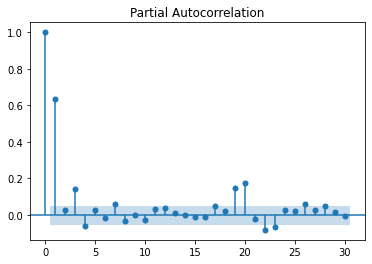

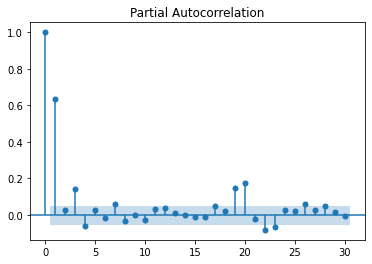

In [171]:
tsaplots.plot_pacf(dfs["daily_units"], lags=30)

In [150]:
predict = res.get_prediction()
predict = predict.predicted_mean

In [151]:
predict

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       2.485544
          ...   
1417    0.809413
1418    0.223691
1419    0.061820
1420    0.638393
1421    0.797736
Length: 1422, dtype: float64

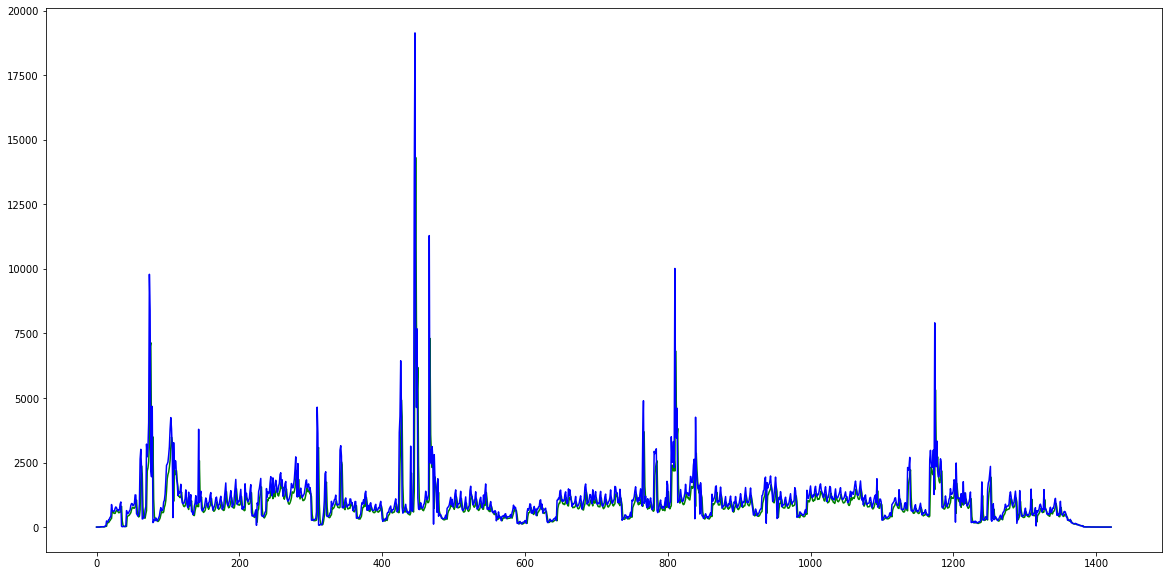

In [152]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(predict, color = "g")
dfs["daily_units"].plot(ax=ax, color = "b")
plt.show()

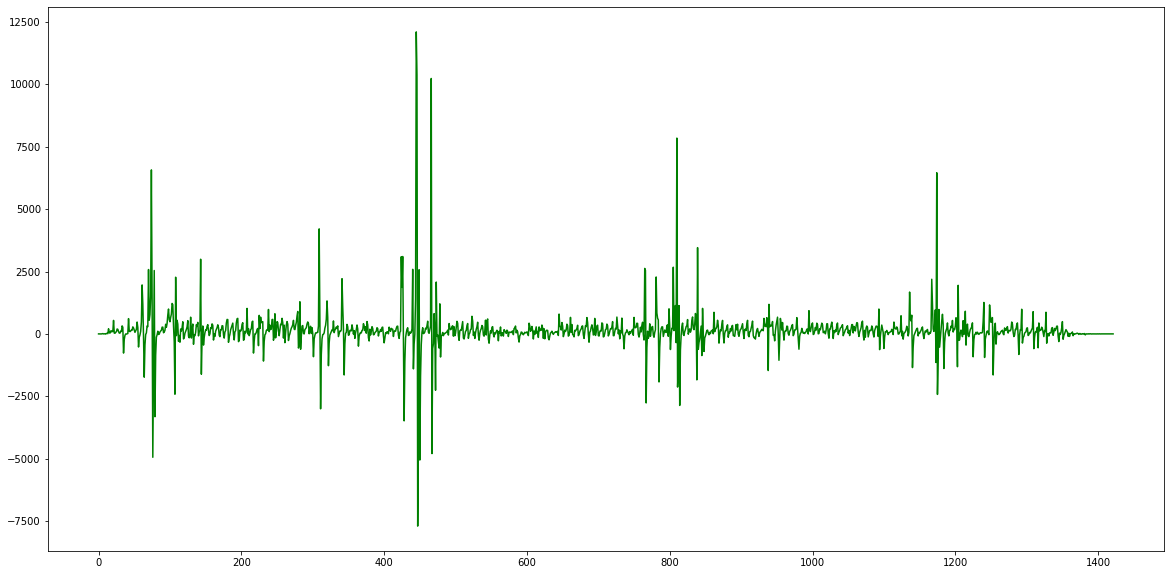

In [153]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(dfs["daily_units"] - predict, color = "g")
plt.show()

In [154]:
dfs["error"] = dfs["daily_units"] - predict

In [127]:
import seaborn as sns

<AxesSubplot: >

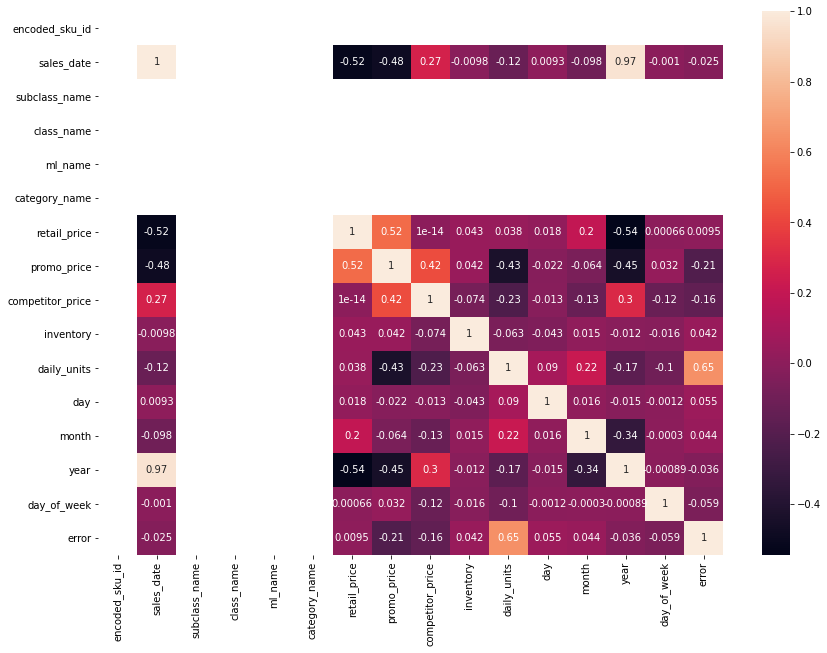

In [155]:
fig,ax =plt.subplots(1,1,figsize=(14,10))
sns.heatmap(dfs.corr(), annot=True, ax=ax)

1415    75.815102
1416    74.560930
1417    72.744584
1418    70.355253
1419    68.618061
1420    67.541596
1421    65.898569
1422    64.296112
dtype: float64

In [112]:
dfs.daily_units.iloc[-7:]

1415    1
1416    1
1417    0
1418    0
1419    1
1420    1
1421    1
Name: daily_units, dtype: int32

853.9166424924791